In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyreadr import read_r
import gc

In [2]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

**<h3>1. Data loading and EDA</h3>**

1.1 Load Train and Test Dataset, make them dataframes

In [3]:
train_data = read_r('data/train.rds')
test_data = read_r('data/test.rds')

In [4]:
train_df = train_data[None]
test_df = test_data[None]

In [5]:
del train_data
del test_data
gc.collect()

206

In [6]:
#We are given labels for Train set
train_df.head(3)

,SampleID,CellType,IGLV3-19,IGHV4-34,IGKC,IGHA1,IGLC3,S100A2,SCGB3A1,IGHG1,...,AC092794.2,AC016722.3,LINC01119,LINC01291,AC010132.4,C7orf69,AL672277.1,FAM66D,AC007298.2,AL139022.2
rownames,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGATATACG_2,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGAGCGTGAAC_2,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGAGCTACCTA_2,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
#We are not given labels for Test set
test_df.head(3)

,SampleID,IGLV3-19,IGHV4-34,IGKC,IGHA1,IGLC3,S100A2,SCGB3A1,IGHG1,BPIFA1,...,AC092794.2,AC016722.3,LINC01119,LINC01291,AC010132.4,C7orf69,AL672277.1,FAM66D,AC007298.2,AL139022.2
rownames,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGACACTAA_1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGAGGAGTACC_1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGAGGATATAC_1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**1.2 General Metrics (Train set)**

In [8]:
var_by_Gene = train_df.iloc[:, 2:].var()
mean_by_Gene = train_df.iloc[:, 2:].mean()

In [9]:
pd.DataFrame({
    'Metric': ['Mean Expression', 'Median Variance', 'Zero Ratio', 'Comment'],
    'Values': [mean_by_Gene.mean(), 
               var_by_Gene.median(),
               (train_df.iloc[:, 2:] == 0).sum().sum() /  train_df.iloc[:, 2:].size,
               'Very Sparse !']
})

,Metric,Values
0,Mean Expression,0.24339
1,Median Variance,0.001867
2,Zero Ratio,0.951939
3,Comment,Very Sparse !


mean expression is 0.24 since most of them is 0

**1.3 Top 10 Genes**

1.3.1 Most Expressed

In [10]:
top_10_genes = mean_by_Gene.sort_values(ascending=False).head(10)

In [11]:
pd.DataFrame({
    'Gene':top_10_genes.index.to_list(),
    'Mean':top_10_genes.values.tolist(),
    'Variance': var_by_Gene[top_10_genes.index.to_list()].values.tolist()
})

,Gene,Mean,Variance
0,CD74,67.735965,20681.549180
1,APOC1,62.592661,26926.408658
2,CCL2,50.338299,11655.298804
3,HLA-DRA,41.255103,5383.881679
4,S100A6,33.135823,2235.936598
5,HLA-DRB1,31.343684,4592.978040
6,MT-ND3,28.315856,1645.625256
7,MT-CO3,27.857212,2626.779998
8,HLA-A,27.205862,2328.307377
9,ISG15,25.552772,1349.995433


1.3.2 Most Variable

In [12]:
top_10_genes = var_by_Gene.sort_values(ascending=False).head(10)

In [13]:
pd.DataFrame({
    'Gene':top_10_genes.index.to_list(),
    'Mean':top_10_genes.values.tolist(),
    'Variance': var_by_Gene[top_10_genes.index.to_list()].values.tolist()
})

,Gene,Mean,Variance
0,APOC1,26926.408658,26926.408658
1,CD74,20681.549180,20681.549180
2,CCL2,11655.298804,11655.298804
3,IGKV3-20,10058.526354,10058.526354
4,IGLV2-14,8559.494879,8559.494879
5,IGKV1D-13,6628.418487,6628.418487
6,HLA-DRA,5383.881679,5383.881679
7,IGKV3-11,4850.854421,4850.854421
8,HLA-DRB1,4592.978040,4592.978040
9,APOE,4103.631986,4103.631986


In [14]:
del top_10_genes

1.3.3 Relationship of them

In [15]:
np.corrcoef(mean_by_Gene.values, var_by_Gene.values)

array([[1.        , 0.70265232],
       [0.70265232, 1.        ]])

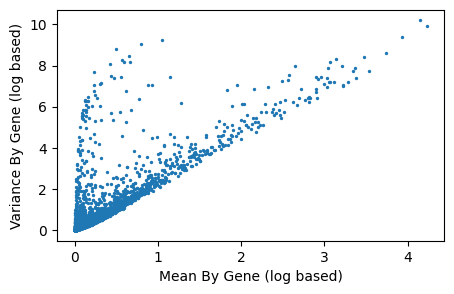

In [16]:
plt.figure(figsize=(5,3))
plt.scatter(np.log1p(mean_by_Gene.values), np.log1p(var_by_Gene.values), s = 2)
plt.xlabel('Mean By Gene (log based)')
plt.ylabel('Variance By Gene (log based)')
plt.show()

In [17]:
del mean_by_Gene

1.4 Data Distribution

+ Proportion of each label 

In [18]:
labels = train_df['CellType'].to_numpy().astype('int8')

unique, counts = np.unique(labels, return_counts=True)

In [19]:
pd.DataFrame({
    'labels': unique,
    'ratio': counts * 100 / sum(counts)
})

,labels,ratio
0,1,1.447873
1,2,79.861984
2,3,2.676470
3,4,1.254394
4,5,0.209603
5,6,0.067718
6,7,11.931250
7,8,1.802586
8,9,0.212828
9,10,0.535294


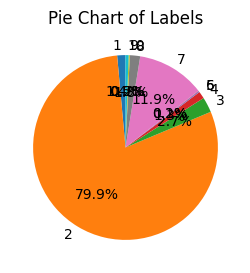

In [20]:
plt.figure(figsize=(3, 3))
plt.pie(counts, labels=[f'{val}' for val in unique], autopct='%1.1f%%', startangle=90)
plt.title('Pie Chart of Labels')
plt.show()

-> We see Extreme Class Imbalace

Where Cell type 2 dominates all classes at ~ 80%, this can create a lot of biases towards **label 2** in the training process

+ Gene distribution

-> I will pick top 10 most variable genes for visualization

In [21]:
top_10_genes = var_by_Gene.sort_values(ascending=False).head(10)

In [22]:
top_10_var_names = top_10_genes.index.tolist()
high_variable_df = train_df.loc[:, top_10_var_names]

Text(0.5, 0, 'Gene Expression')

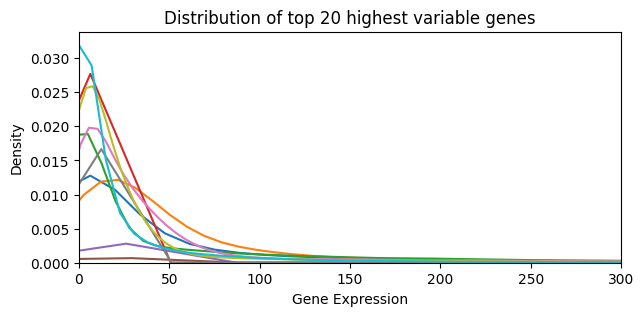

In [23]:
plt.figure(figsize=(7, 3))
for gene in top_10_var_names:
    sns.kdeplot(high_variable_df.loc[:, gene], label = gene)

plt.xlim([0,300])
plt.title('Distribution of top 20 highest variable genes')
plt.xlabel('Gene Expression')

In [24]:
del top_10_genes
del top_10_var_names
del high_variable_df

gc.collect()

3144

1.5 Gene activity per cell type

In [25]:
x = train_df.groupby('CellType').mean().iloc[:, 1:]

<Axes: ylabel='CellType'>

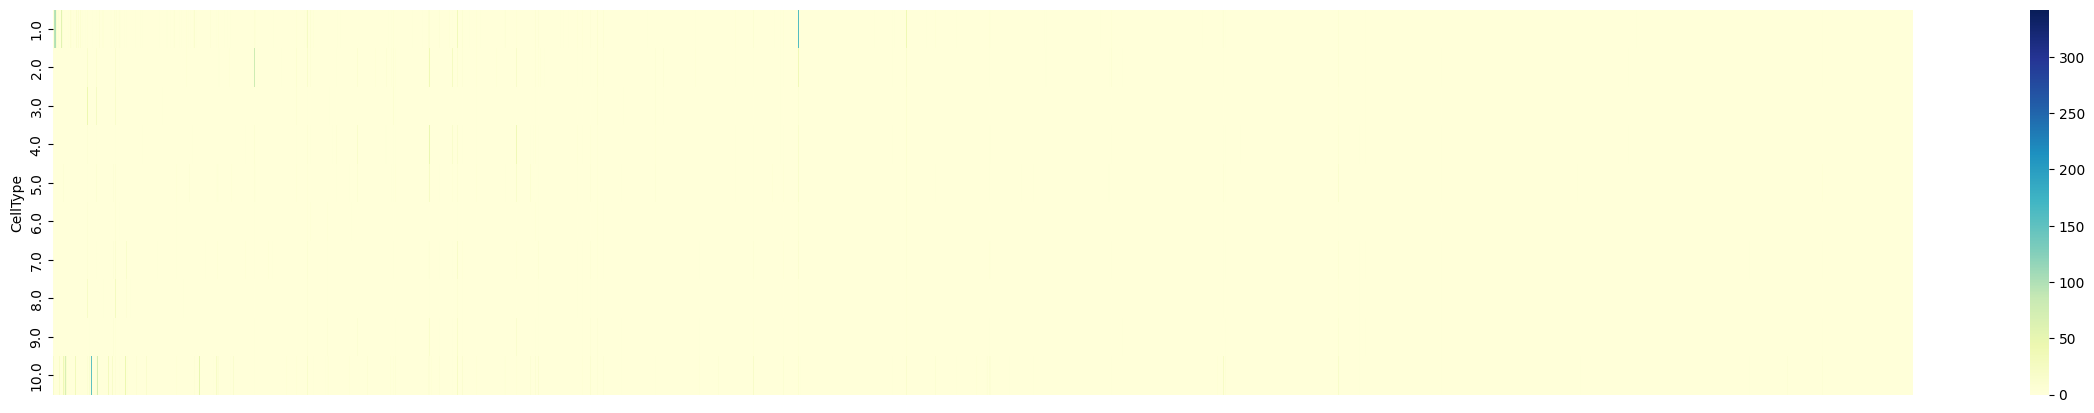

In [26]:
plt.figure(figsize=(30, 5))
sns.heatmap(data=x, cmap="YlGnBu", xticklabels=False, linecolor='gray')

#Definitely, some genes are very active in one specific class ! We will use them as Marker Genes

In [27]:
del x
gc.collect()

5

**<h3> 2. Feature Engineering </h3>**

**2.1 Stabilize Data**

2.1.1 Split Gene Matrix and Label vector

In [28]:
#train set
train_genes = train_df.iloc[:, 2:]
train_labels = train_df['CellType']

In [29]:
#test set
test_genes = test_df.iloc[:, 1:]

2.1.2 Remove Gene with low variance

In [30]:
#Remove Gene with low var on train set
selector = VarianceThreshold(threshold = 0.01)
reduced_train_genes = selector.fit_transform(train_genes)

In [31]:
selected_columns = train_genes.columns[selector.get_support()]
reduced_train_genes = pd.DataFrame(reduced_train_genes, columns=selected_columns)

In [32]:
#Apply the same on test set using selected columns from train
reduced_test_genes = test_genes.loc[:, selected_columns]

2.1.3 Log transformation to reduce skewness

In [33]:
log_reduced_train_genes = np.log1p(reduced_train_genes)
log_reduced_test_genes  = np.log1p(reduced_test_genes)

**2.2 Dimensionality Reduction using PCA**

2.2.1 Prepare data for PCA

We will be using top 2000 variable genes as input for PCA

In [34]:
k = 2000

top_k_genes = var_by_Gene.sort_values(ascending=False).head(k)

In [35]:
centered_data = log_reduced_train_genes - log_reduced_train_genes.mean()

In [36]:
top_k_names = top_k_genes.index.tolist()

X_top_K = centered_data.loc[:, top_k_names].to_numpy()

2.2.2 Fit PCA

In [37]:
pca = PCA(n_components=2000)
X_pca = pca.fit_transform(X_top_K)

2.2.3 Show Cumulative Coverage + Scree Plot

In [38]:
cumulative_ratio = np.cumsum(pca.explained_variance_ratio_)

In [39]:
pd.DataFrame({
    'PC':np.arange(1, 11, 1),
    'Variance Explained': pca.explained_variance_ratio_[:10],
    'Cumulative Variance Explained': cumulative_ratio[:10]
})

,PC,Variance Explained,Cumulative Variance Explained
0,1,0.288992,0.288992
1,2,0.137180,0.426172
2,3,0.051477,0.477649
3,4,0.020058,0.497707
4,5,0.016031,0.513738
5,6,0.013581,0.527319
6,7,0.010996,0.538315
7,8,0.009673,0.547988
8,9,0.008957,0.556945
9,10,0.006911,0.563856


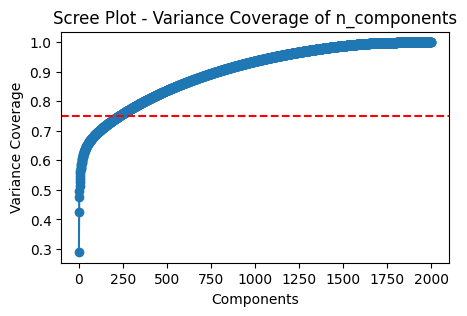

In [40]:
plt.figure(figsize=(5, 3))
plt.plot(range(1, len(cumulative_ratio) + 1), cumulative_ratio, marker='o')
plt.axhline(y=0.75, color='r', linestyle='--', label='95% variance')
plt.title('Scree Plot - Variance Coverage of n_components')
plt.xlabel('Components')
plt.ylabel('Variance Coverage')
plt.show()

In [41]:
del cumulative_ratio

***2.2.4 PCA dataframe**

+ We would use around 250 Components, it will cover around 75% of the variation

a. Train Set

In [42]:
train_PCA = pd.DataFrame(
    X_pca[:, :250],
    columns=[f'PC{i}' for i in range(1, 251)]
)

b. Test Set

In [43]:
centered_data = log_reduced_test_genes - log_reduced_test_genes.mean()

In [44]:
X_top_K = centered_data.loc[:, top_k_names].to_numpy()

In [45]:
X_pca = pca.transform(X_top_K)

In [46]:
test_PCA = pd.DataFrame(
    X_pca[:, :250],
    columns=[f'PC{i}' for i in range(1, 251)]
)

Clean Data

In [47]:
del pca
del X_top_K
del X_pca
del centered_data
gc.collect()

3665

**2.3. Marker Genes**

A gene can be more active in one cell type than in another (shown in EDA), we can use that fact to create more **supportive features**

2.3.1 Heatmap to support idea

<Axes: title={'center': 'Gene Intensity per Cell Class'}, ylabel='CellType'>

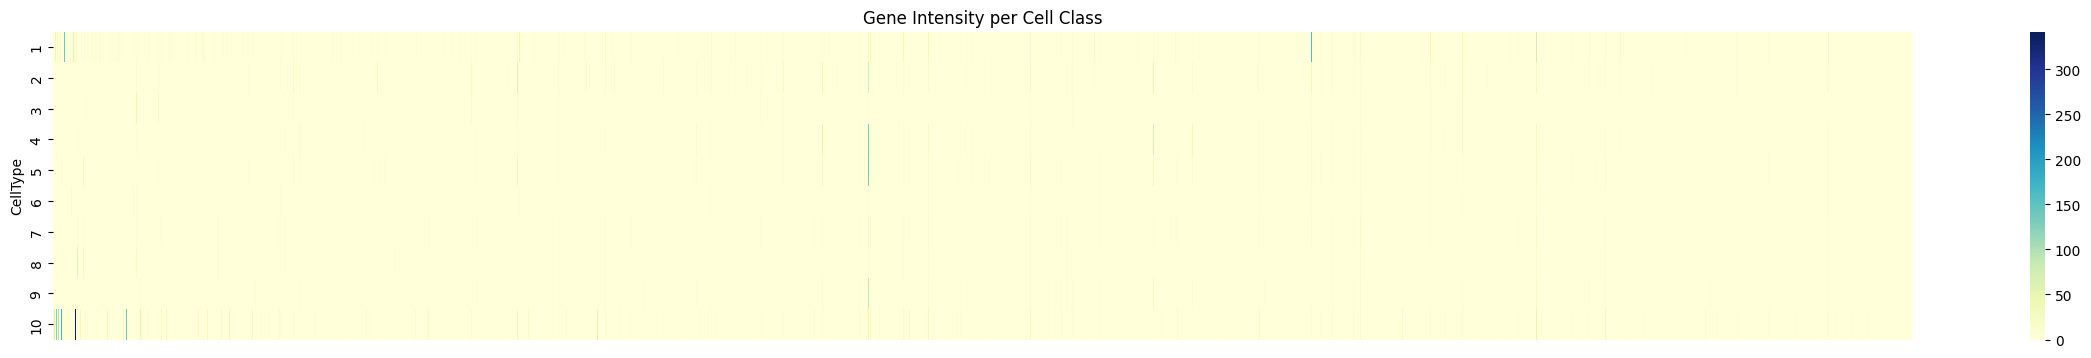

In [48]:
x = pd.concat([pd.DataFrame({'CellType': labels}), reduced_train_genes], axis=1).groupby('CellType').mean().iloc[:, 1:]
plt.figure(figsize=(30, 4))
plt.title('Gene Intensity per Cell Class')
sns.heatmap(data=x, cmap="YlGnBu", xticklabels=False, linecolor='gray')

2.3.2 Log Fold Change

Constrains:

1. Log FC >= 1
2. detect_diff > (80-20) = 0.6

<i>Overall</i>: Score >= 0.4 (Very strict)

In [96]:
def find_marker_genes(data, labels, cell_type, threshold, k, epsilon=1e-6):

    '''
    This function returns top k marker genes ranked by Harmonized Score
    '''

    current_label = data[labels == cell_type]
    other_labels = data[labels != cell_type]

    in_means = current_label.mean() + epsilon
    out_means = other_labels.mean() + epsilon

    log_FC = np.log2(in_means / out_means)

    in_detect = (current_label > 0).sum() / len(current_label)
    out_detect = (other_labels > 0).sum() / len(other_labels)

    detect_diff = in_detect - out_detect

    #harmonized score
    score = (2 * log_FC * detect_diff) / (log_FC + detect_diff)

    score = score[score >= threshold]

    score = score.sort_values(ascending=False).head(k)

    return score.index.tolist()

In [173]:
all_markers = set()
unique_markers = {}

for cell_type in np.unique(labels):
    found_markers = find_marker_genes(reduced_train_genes, labels, cell_type, 0.5, 10)

    all_markers.update(found_markers)

    unique_markers[cell_type] = [marker for marker in found_markers if (marker in all_markers)]

all_markers = list(all_markers)

In [180]:
#For each cell type we do have around 10 distinct Marker Genes
len(all_markers)

97

2.3.3 We want to visualize how Marker Genes behave

In [177]:
train_marker_gene = reduced_train_genes.loc[:, list(all_markers)]

<Axes: title={'center': 'Marker Gene Intensity per Cell Class'}, ylabel='CellType'>

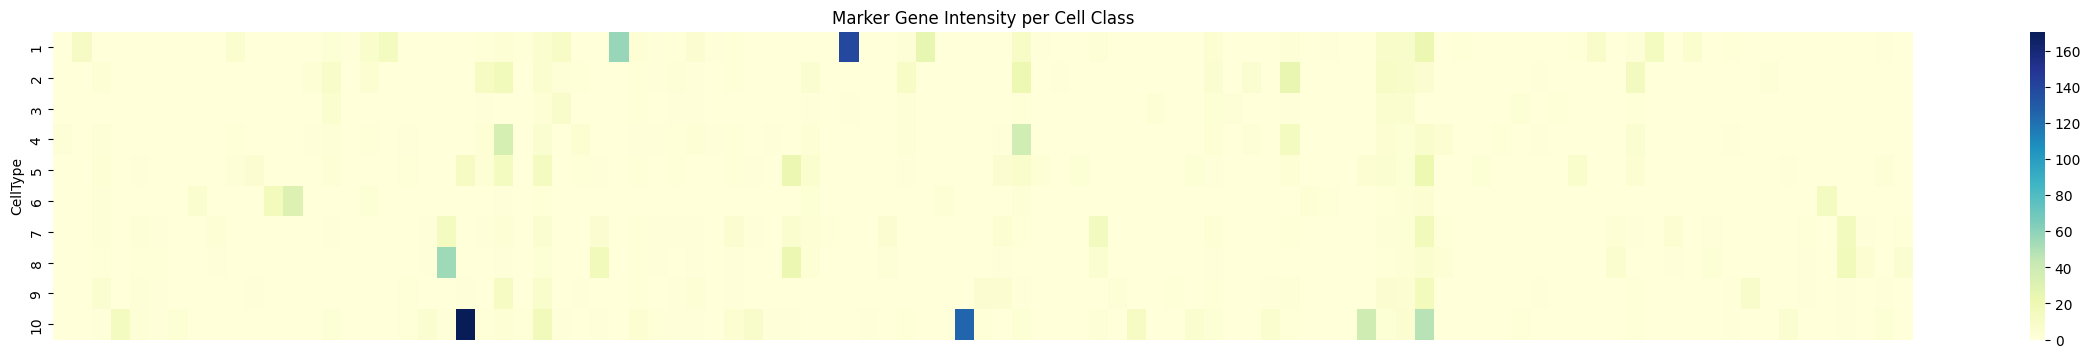

In [181]:
x = pd.concat([pd.DataFrame({'CellType': labels}), train_marker_gene], axis=1).groupby('CellType').mean()
plt.figure(figsize=(30, 4))
plt.title('Marker Gene Intensity per Cell Class')
sns.heatmap(data=x, cmap="YlGnBu", xticklabels=False, linecolor='gray')

In [ ]:
breakhere()

**<h3>4. Experimental Design</h3>**

We are running multiple Machine Learning models and benchmark them to find the best of all.


For each model:
+ We are running 30 simulations

+ -> For each simulation, we will have 5 Fold Cross Validation (We fit on 80% of data and 20% for validation) 

4.1 Design a simulation matrix

+ An N_simulations x M_samples matrix of Indices (each simulation contains 5 Folds, where each is a stratified collection of samples)

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True)

In [ ]:
#We design this CV matrix for all models
simulations = []
for sim in range(30):
    folds = []
    for train_idx, val_idx in skf.split(X_res, y_res):
        folds.append((train_idx, val_idx))
    simulations.append(folds)

del folds

4.2 Collection of models

+ Run, save metrics for benchmarking

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
n_sim = 20

4.2.1 K-nearest neighbors (KNN)

In [ ]:
k_values = [10, 20, 30]

In [ ]:
simulation_score = np.repeat(0.0, n_sim * 3 * len(k_values)).reshape(-1, n_sim, 3) #precision, recall and F1_score tensor

In [ ]:
for k_value_id in range(len(k_values)):

    #We are running a collection of k_values
    knn = KNeighborsClassifier(n_neighbors=k_values[k_value_id])

    for sim_id in range(n_sim):
        precision = 0.0
        recall = 0.0
        f1 = 0.0

        for cv_id in range(5):

            train_indices = simulations[sim_id][cv_id][0]
            test_indices = simulations[sim_id][cv_id][1]

            #Prepare Data for fit and test
            X_train = X_res[train_indices,:]
            y_train = y_res[train_indices]

            X_test = X_res[test_indices,:]
            y_test = y_res[test_indices]

            #fitting
            knn.fit(X_train, y_train)

            #make predictions
            y_pred = knn.predict(X_test)

            #Save metrics
            precision = precision + precision_score(y_true=y_test, y_pred=y_pred, average='weighted')
            recall = recall + recall_score(y_true=y_test, y_pred=y_pred, average='weighted')
            f1 = f1 + f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
    
    
        #Average to get metrics for 1 simulation
        precision = precision / 5
        recall = recall / 5
        f1 = f1 / 5

        #record to measurement table
        simulation_score[k_value_id, sim_id, 0] = precision #Column 0 is precision
        simulation_score[k_value_id, sim_id, 1] = recall    #Column 1 is recall
        simulation_score[k_value_id, sim_id, 2] = f1        #Column 2 is f1 score

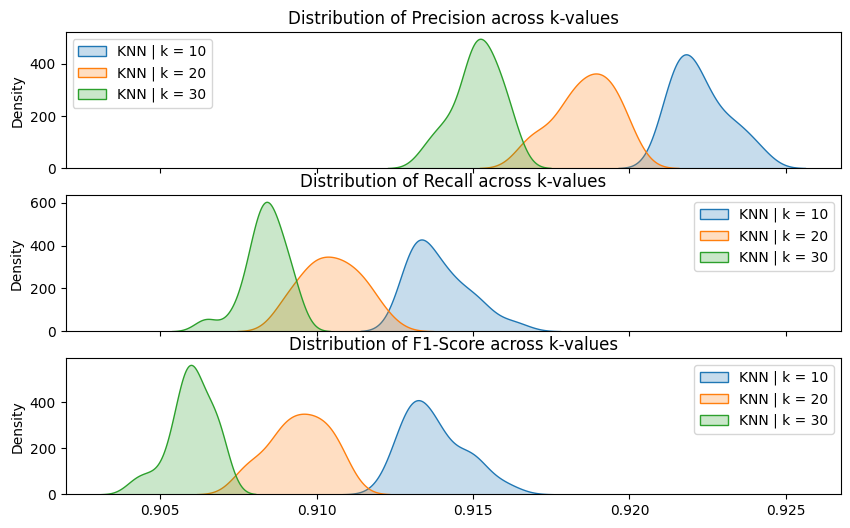

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
metrics = ['Precision', 'Recall', 'F1-Score']
#Plot Precision
for metric_id in range(3):

    for k_value_id in range(len(k_values)):

        sns.kdeplot(simulation_score[k_value_id, :, metric_id], 
                    ax = axes[metric_id],
                    label=f'KNN | k = {k_values[k_value_id]}',fill=True)

    axes[metric_id].set_title(f'Distribution of {metrics[metric_id]} across k-values')
    axes[metric_id].legend()

plt.show()

The simulation plots show that KNN(k=10) is good. We are going for k=10

+ Fit on all Dataset and test on Validation

In [ ]:
knn = KNeighborsClassifier(n_neighbors=10)

In [ ]:
knn.fit(X_res, y_res)

KNeighborsClassifier(n_neighbors=10)

In [ ]:
y_pred = knn.predict(X_validate)

In [ ]:
print('Classification report for KNN with k=10\n')
print(classification_report(y_true=y_validate, y_pred=y_pred))

Classification report for KNN with k=10

              precision    recall  f1-score   support

           1       1.00      0.90      0.95        10
           2       0.69      0.90      0.78        10
           3       0.80      0.80      0.80        10
           4       0.88      0.70      0.78        10
           5       1.00      0.90      0.95        10
           6       0.77      1.00      0.87        10
           7       0.71      1.00      0.83        10
           8       1.00      0.60      0.75        10
           9       0.89      0.80      0.84        10
          10       1.00      0.90      0.95        10

    accuracy                           0.85       100
   macro avg       0.87      0.85      0.85       100
weighted avg       0.87      0.85      0.85       100



In [ ]:
del knn
del y_pred
gc.collect()

10921

4.2.2 Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
n_estimator_value = [50, 100, 150]

In [ ]:
n_sim = 20

In [ ]:
simulation_score = np.repeat(0.0, n_sim * 3 * len(n_estimator_value)).reshape(-1, n_sim, 3) #precision, recall and F1_score tensor

In [ ]:
for n_estimator_id in range(len(n_estimator_value)):

    #We are running a collection of k_values
    rf = RandomForestClassifier(n_estimators=n_estimator_value[n_estimator_id],
                                max_depth=20, 
                                random_state=42)

    for sim_id in range(n_sim):
        precision = 0.0
        recall = 0.0
        f1 = 0.0

        for cv_id in range(5):

            train_indices = simulations[sim_id][cv_id][0]
            test_indices = simulations[sim_id][cv_id][1]

            #Prepare Data for fit and test
            X_train = X_res[train_indices,:]
            y_train = y_res[train_indices]

            X_test = X_res[test_indices,:]
            y_test = y_res[test_indices]

            #fitting
            rf.fit(X_train, y_train)

            #make predictions
            y_pred = rf.predict(X_test)

            #Save metrics
            precision = precision + precision_score(y_true=y_test, y_pred=y_pred, average='weighted')
            recall = recall + recall_score(y_true=y_test, y_pred=y_pred, average='weighted')
            f1 = f1 + f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
    
    
        #Average to get metrics for 1 simulation
        precision = precision / 5
        recall = recall / 5
        f1 = f1 / 5

        #record to measurement table
        simulation_score[n_estimator_id, sim_id, 0] = precision #Column 0 is precision
        simulation_score[n_estimator_id, sim_id, 1] = recall    #Column 1 is recall
        simulation_score[n_estimator_id, sim_id, 2] = f1        #Column 2 is f1 score

    print(f'Finish RF with n={n_estimator_value[n_estimator_id]}')

Finish RF with n=50
Finish RF with n=100
Finish RF with n=150


+ Visualization of simulation

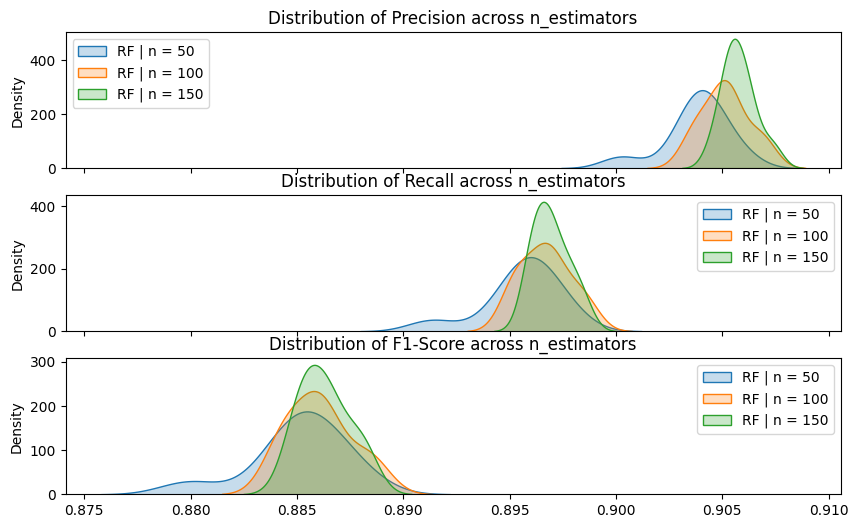

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
metrics = ['Precision', 'Recall', 'F1-Score']

for metric_id in range(3):

    for n_estimator_id in range(len(n_estimator_value)):

        sns.kdeplot(simulation_score[n_estimator_id, :, metric_id], 
                    ax = axes[metric_id],
                    label=f'RF | n = {n_estimator_value[n_estimator_id]}',fill=True)

    axes[metric_id].set_title(f'Distribution of {metrics[metric_id]} across n_estimators')
    axes[metric_id].legend()

plt.show()

+ The simulation plots show that n_est = 150 is good.

In [ ]:
rf = RandomForestClassifier(n_estimators=150,
                                max_depth=20, 
                                random_state=42)

In [ ]:
rf.fit(X_res, y_res)

RandomForestClassifier(max_depth=20, n_estimators=150, random_state=42)

In [ ]:
y_pred = rf.predict(X_validate)

In [ ]:
print('Classification report for Random Forest with n_est= 150\n')
print(classification_report(y_true=y_validate, y_pred=y_pred))

Classification report for Random Forest with n_est= 150

              precision    recall  f1-score   support

           1       0.99      0.83      0.91       200
           2       0.77      1.00      0.87      1000
           3       1.00      0.41      0.58       200
           4       0.91      0.26      0.41        80
           5       1.00      0.63      0.78        30
           6       0.00      0.00      0.00        10
           7       0.89      0.93      0.91       700
           8       0.97      0.32      0.48       100
           9       1.00      0.60      0.75        30
          10       1.00      0.75      0.86       100

    accuracy                           0.84      2450
   macro avg       0.85      0.57      0.65      2450
weighted avg       0.86      0.84      0.82      2450



In [ ]:
del rf
del y_pred
gc.collect()

44

4.2.3 Support Vector Machines

In [ ]:
from sklearn.svm import SVC

In [ ]:
n_sim = 20

C_values = [0.1, 1, 10]

In [ ]:
simulation_score = np.repeat(0.0, n_sim * 3 * len(C_values)).reshape(-1, n_sim, 3) #precision, recall and F1_score tensor

In [ ]:
for c_val_id in range(len(C_values)):

    svm = SVC(kernel='linear', C=C_values[c_val_id], gamma='scale') 

    for sim_id in range(n_sim):
        precision = 0.0
        recall = 0.0
        f1 = 0.0

        for cv_id in range(5):

            train_indices = simulations[sim_id][cv_id][0]
            test_indices = simulations[sim_id][cv_id][1]

            #Prepare Data for fit and test
            X_train = X_res[train_indices,:]
            y_train = y_res[train_indices]

            X_test = X_res[test_indices,:]
            y_test = y_res[test_indices]

            #fitting
            svm.fit(X_train, y_train)

            #make predictions
            y_pred = svm.predict(X_test)

            #Save metrics
            precision = precision + precision_score(y_true=y_test, y_pred=y_pred, average='weighted')
            recall = recall + recall_score(y_true=y_test, y_pred=y_pred, average='weighted')
            f1 = f1 + f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
    
    
        #Average to get metrics for 1 simulation
        precision = precision / 5
        recall = recall / 5
        f1 = f1 / 5

        #record to measurement table
        simulation_score[c_val_id, sim_id, 0] = precision #Column 0 is precision
        simulation_score[c_val_id, sim_id, 1] = recall    #Column 1 is recall
        simulation_score[c_val_id, sim_id, 2] = f1        #Column 2 is f1 score

    print(f'Finish SVMs with c={C_values[c_val_id]}')

Finish SVMs with c=0.1
Finish SVMs with c=1
Finish SVMs with c=10


+ Visualization of simulation

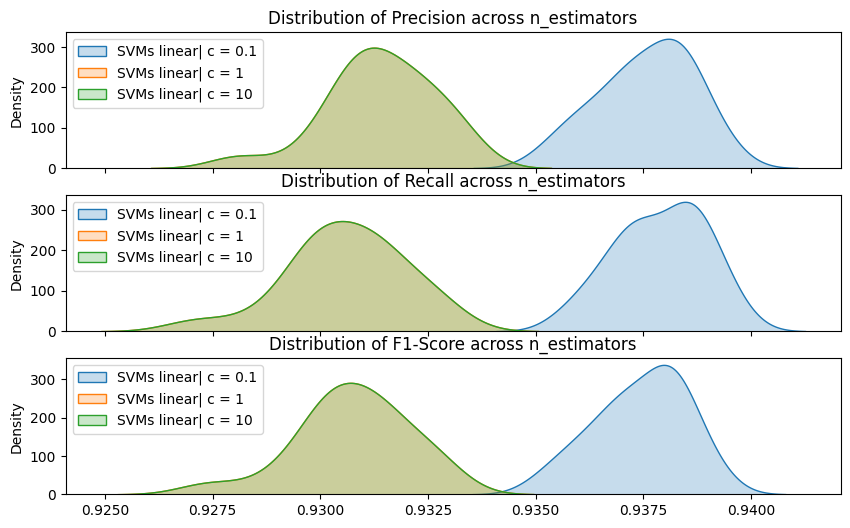

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
metrics = ['Precision', 'Recall', 'F1-Score']

for metric_id in range(3):

    for c_val_id in range(len(C_values)):

        sns.kdeplot(simulation_score[c_val_id, :, metric_id], 
                    ax = axes[metric_id],
                    label=f'SVMs linear| c = {C_values[c_val_id]}',fill=True)

    axes[metric_id].set_title(f'Distribution of {metrics[metric_id]} across n_estimators')
    axes[metric_id].legend()

plt.show()

It seems to be that high regularization (c=10) is pretty much the same as (c=1)

!!! Although CV shows c=0.1 outperforms c=1, validation says otherwise

**C=0.1**

In [ ]:
svm = SVC(kernel='linear', C=0.1, gamma='scale') 

In [ ]:
svm.fit(X_res, y_res)

SVC(C=0.1, kernel='linear')

In [ ]:
y_pred = svm.predict(X_validate)

In [ ]:
print('Classification report for SVMs (kernel = linear) with c= 0.1\n')

print(classification_report(y_true=y_validate, y_pred=y_pred))

Classification report for SVMs (kernel = linear) with c= 0.1

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        10
           2       0.57      0.80      0.67        10
           3       0.69      0.90      0.78        10
           4       0.75      0.60      0.67        10
           5       1.00      1.00      1.00        10
           6       1.00      0.90      0.95        10
           7       0.77      1.00      0.87        10
           8       1.00      0.70      0.82        10
           9       1.00      0.80      0.89        10
          10       1.00      0.80      0.89        10

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100



**C=1**

In [ ]:
svm = SVC(kernel='linear', C=1, gamma='scale') 

In [ ]:
svm.fit(X_res, y_res)

SVC(C=1, kernel='linear')

In [ ]:
y_pred = svm.predict(X_validate)

In [ ]:
print('Classification report for SVMs (kernel = linear) with c= 1\n')

print(classification_report(y_true=y_validate, y_pred=y_pred))

Classification report for SVMs (kernel = linear) with c= 1

              precision    recall  f1-score   support

           1       0.98      0.94      0.96       200
           2       0.96      0.98      0.97      5000
           3       0.83      0.76      0.79       300
           4       0.69      0.56      0.62       150
           5       1.00      0.80      0.89        30
           6       0.88      0.70      0.78        10
           7       0.93      0.92      0.93      1000
           8       0.79      0.79      0.79       200
           9       0.96      0.83      0.89        30
          10       0.99      0.85      0.91        80

    accuracy                           0.94      7000
   macro avg       0.90      0.81      0.85      7000
weighted avg       0.94      0.94      0.94      7000



In [ ]:
del svm
del y_pred

gc.collect()

0

**<h3>5. Conclusion</h3>**

+ We have resampled data using SMOTE (we also sacrified a lot of cells of type 2 for balancing)

+ We have explored only 3 models but SVMs shows pretty good performance on most classes. Especially class 6 is the minor one but it achieved an F1 score of **0.95**